# **Lab 13c: Diffusion Models**

Code was adapted from [here](https://colab.research.google.com/drive/1YUFwGs0z0lEaBUpSdJIEZtCATe44TUjw?usp=sharing&authuser=5).


In [1]:
# Tutorial on diffusion models
# Original Source: https://colab.research.google.com/drive/1YUFwGs0z0lEaBUpSdJIEZtCATe44TUjw?usp=sharing&authuser=5
# Used for CS 1674: Intro to Computer Vision Course (Univ of Pittsburgh)
#
# author: Phillip Isola
# last modified: 6/6/23

In [2]:
# imports and installs
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torchvision.utils as vutils
!pip install einops
import einops

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 584kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


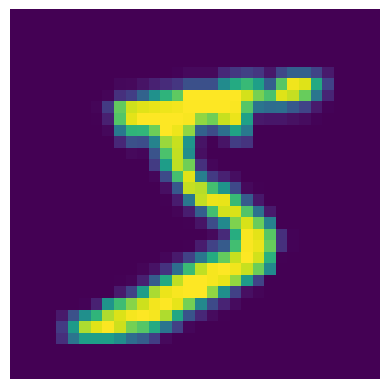

In [3]:
## download mnist dataset from torchvision.datasets and display the first image

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to 32x32 (powers of 2 are just easier to work with)
    transforms.ToTensor()         # Convert the image to a PyTorch tensor
])

# Download the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Display the first image
image, label = train_dataset[0]
plt.imshow(image.permute(1, 2, 0))  # Convert tensor shape from CxHxW to HxWxC
plt.axis('off')
plt.show()


In [4]:
## extract from train_dataset a tensor of all the images in format BxCxHxW and a tensor of all the labels in format Bx1

# Extract images and labels
images = torch.stack([image for image, _ in train_dataset], dim=0)
labels = torch.tensor([label for _, label in train_dataset]).unsqueeze(1)

In [5]:
# inspect the data
def inspect_data(X):
  print('type:', X.type())
  print('shape:', X.shape)
  print('numerical range: [{:.2f}, {:.2f}]'.format(X.min(), X.max()))
  print('mean and var: {:.2f}, {:.2f}'.format(X.mean(), X.var()))

inspect_data(images)

type: torch.FloatTensor
shape: torch.Size([60000, 1, 32, 32])
numerical range: [0.00, 1.00]
mean and var: 0.13, 0.08


In [6]:
## create noisy images. this becomes your training data

# make a new tensor NxBxCxHxW, which will contain the sequence of noisier and noisier images, for N noise levels
T = 6
B = images.shape[0]
C = images.shape[1]
H = images.shape[2]
W = images.shape[3]

def forward_diffusion(images):
  diffusion_images = torch.zeros([T, B, C, H, W])

  # populate the first noise level with the uncorrupted images
  diffusion_images[0,:,:,:,:] = images

  # compute diffused images by adding a sequence of Gaussian noise to the first image in sequence
  betas = torch.linspace(0.1, 0.7, T-1)
  for t in range(T-1):
    diffusion_images[t+1,:,:,:,:] = torch.sqrt(1-betas[t])*diffusion_images[t,:,:,:,:] + betas[t]*torch.randn(B,C,H,W)

  return diffusion_images

diffusion_images = forward_diffusion(images)

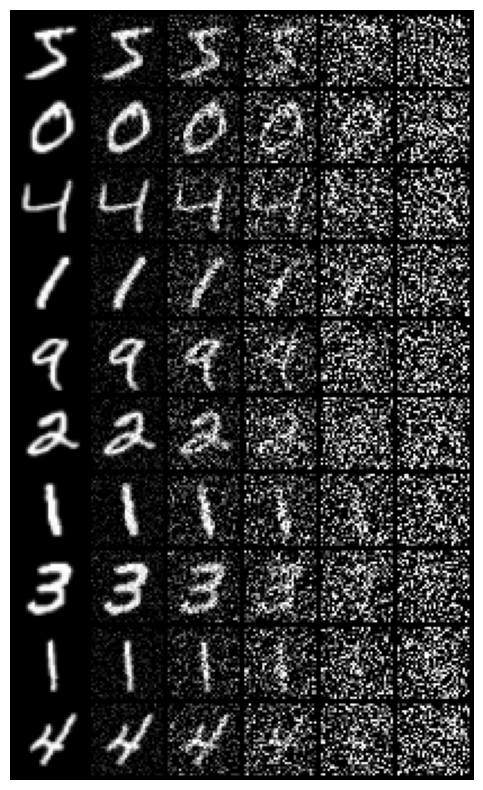

In [7]:
# visualize some forward diffusion sequences

def display_images(X,B=10):
  ''' B is how many images to display '''

  T = X.shape[0]

  # display a tensor, X, of shape T x B x C x H x W as a grid of shape B x T of images of size H x W x C

  # Reshape the tensor for plotting
  to_display = einops.rearrange(X[:,:B,:,:,:], 'B T C H W -> (T B) C H W')
  to_display = vutils.make_grid(to_display, nrow=T, normalize=False)

  # Display the grid of images
  plt.figure(figsize=(10, 10))
  plt.imshow(to_display.permute(1, 2, 0).cpu())
  plt.axis('off')
  plt.show()

display_images(diffusion_images)

In [8]:
# define denoising network architecture
## ChatGPT (but you will have to edit it): "a pytorch definition of a u-net with 4 encoder layers and 4 decoder layers"

from torch import nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        nf = 128 # controls number of channels

        # Encoding layers
        self.enc1 = self.conv_bn_relu(1, nf, padding=1)
        self.enc2 = self.conv_bn_relu(nf, nf*2, padding=1)
        self.enc3 = self.conv_bn_relu(nf*2, nf*4, padding=1)
        self.enc4 = self.conv_bn_relu(nf*4, nf*8, padding=1)

        # Decoding layers
        self.dec4 = self.conv_transpose_bn_relu(nf*8, nf*4, padding=1)
        self.dec3 = self.conv_transpose_bn_relu(nf*8, nf*2, padding=1)
        self.dec2 = self.conv_transpose_bn_relu(nf*4, nf, padding=1)
        self.dec1 = self.conv_transpose_bn_relu(nf*2, 1, padding=1)

    def forward(self, x):
        # Encoder pathway
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Decoder pathway, with skip connections
        dec4 = self.dec4(enc4)
        dec3 = self.dec3(torch.cat([dec4, enc3], dim=1))
        dec2 = self.dec2(torch.cat([dec3, enc2], dim=1))
        dec1 = self.dec1(torch.cat([dec2, enc1], dim=1))

        return dec1#torch.sigmoid(dec1)

    def conv_bn_relu(self, in_channels, out_channels, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def conv_transpose_bn_relu(self, in_channels, out_channels,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=padding, output_padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

In [9]:
# define function to sample training batch of pairs \{x_t, x_{t-1}\}

def sampleTrainBatch(diffusion_images, bsz):
  ''' bsz is batch size '''

  # sample image indices
  which_images = torch.randperm(diffusion_images.shape[1])[:bsz]
  which_timesteps = (torch.randint(low=1, high=diffusion_images.shape[0]-1, size=(bsz,1))+1).squeeze()

  # sample pairs
  inputs = diffusion_images[which_timesteps, which_images]
  targets = diffusion_images[which_timesteps-1, which_images]

  return inputs.cuda(), targets.cuda()


Inspecting input data:
type: torch.cuda.FloatTensor
shape: torch.Size([10, 1, 32, 32])
numerical range: [-2.07, 2.46]
mean and var: 0.09, 0.25

Inspecting target data:
type: torch.cuda.FloatTensor
shape: torch.Size([10, 1, 32, 32])
numerical range: [-1.95, 1.50]
mean and var: 0.11, 0.14


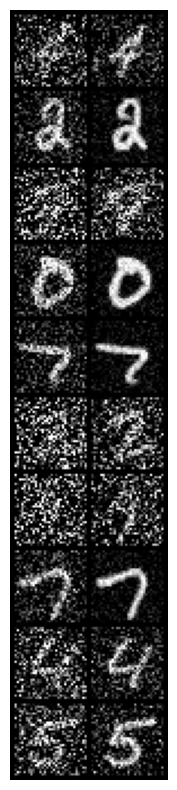

In [10]:
# visualize a training batch

inputs, targets = sampleTrainBatch(diffusion_images, bsz=10)

# inspect the data
print('Inspecting input data:')
inspect_data(inputs)

print('\nInspecting target data:')
inspect_data(targets)

display_images(torch.vstack([inputs.unsqueeze(0), targets.unsqueeze(0)]))

In [11]:
# do supervised learning on f: x_t --> x_{t-1}, using an L2 loss

## ChatpGPT: write a pytorch training loop to train a neural net 'net' using an L2 loss on a batch of intput images 'inputs' whose target outputs are a batch 'targets'

import torch.optim as optim

net = UNet().cuda()

# Initialize a Mean Squared Error (MSE) loss function for L2 loss
criterion = nn.MSELoss()

# Initialize an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Define the number of training iterations
n_train_iter = 5000
bsz = 64

# Set the network to training mode
net.train()

for train_iter in range(n_train_iter):
    # Sample a batch of training data
    inputs, targets = sampleTrainBatch(diffusion_images, bsz)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(inputs)

    # Calculate loss
    loss = criterion(outputs, targets)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    if (train_iter + 1) % 1000 == 1:
        print(f"iter: {train_iter+1}, Loss: {loss.item()}")


iter: 1, Loss: 0.6328966021537781
iter: 1001, Loss: 0.1597115397453308
iter: 2001, Loss: 0.14456862211227417
iter: 3001, Loss: 0.13982629776000977
iter: 4001, Loss: 0.1528993844985962


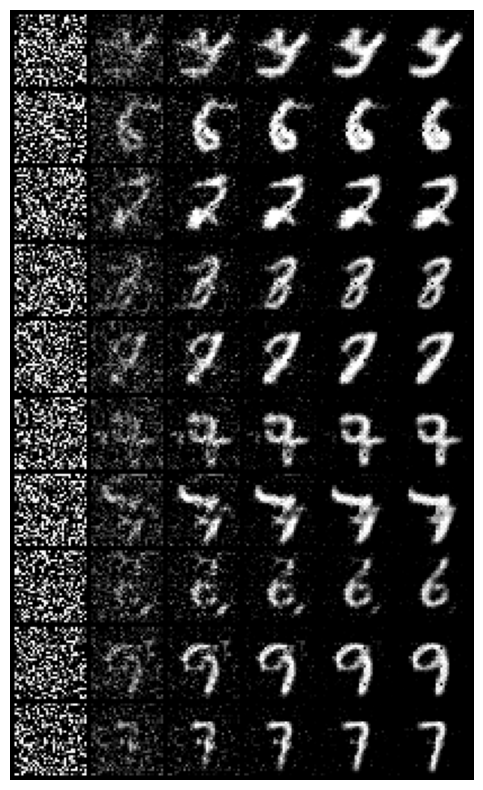

In [12]:
# generate new images

net.train()

# sample noise
B = bsz
noise_input = torch.randn(B,C,H,W).cuda()

# run f on that noise to congeal it onto an image
X = torch.zeros(T,B,C,H,W).cuda()
X[0,:,:,:,:] = noise_input
for t in range(T-1):
  X[t+1,:,:,:,:] = net(X[t,:,:,:,:])

display_images(X[:,:10,:,:])

## Open-ended Exercises

1. Modify the code to train on CIFAR images, rather than MNIST
2. Change the u-net architecture to improve the results
3. In diffusion models, people have found that it helps to predict the noise, then remove this noise, rather than predicting the image (See Eqn. 30.40 and 30.41 in the notes). Try doing this and see if it helps.
4. Rather than predicting x_{t-1} from x_t, some diffusion models try to predict x_0 directly from x_t, and repeating the prediction to get closer an closer to x_0. Try doing this and see if it works better.